Réseau inspiré de http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

(tiré du TP du cours CNN de Mr Bailly)

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

# Import the functions from fgsm.py
#from fgsm_copie import adv_attack, test
from fgsm_copie import adv_attack, test_adv, test_normal

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # convertit les images [H,W,C] dont les valeurs sont dans [0,255] en tenseurs [C,H,W] dont les valeurs sont dans [0,1]
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [7]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [14]:
# Set the hyperparameters
input_dim = 784
num_classes = 10
num_centers = 100
num_epochs = 100
batch_size = 64
learning_rate = 1e-3

epsilon = 0.3
device = torch.device('cpu')

In [8]:

# There we create the class for our Shallow RBF network

class ShallowRBF(nn.Module):
    def __init__(self, input_dim, num_classes, num_centers):
        super(ShallowRBF, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers))
        self.fc = nn.Linear(num_centers, num_classes)

    def forward(self, x):
        
        x = x.view(x.size(0), -1)  # Flatten the input
        # Calculate the RBF activations
        rbf_activations = torch.exp(-self.beta * torch.norm(x.unsqueeze(1) - self.centers, dim=2))

        # Normalize the RBF activations
        rbf_activations = rbf_activations / torch.sum(rbf_activations, dim=1, keepdim=True)

        # Pass the normalized RBF activations through the linear layer
        output = self.fc(rbf_activations)

        return output


# Initialize the model
model1 = ShallowRBF(input_dim, num_classes, num_centers)


architecture de réseau inspirée de ce repository : https://github.com/insujeon/rbfn/blob/master/RBFN_MNIST.ipynb

In [8]:
class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.centers = centers
        self.num_centers = centers.size(0)
        self.num_class = num_class
    
        self.linear = torch.nn.Linear(self.num_centers, self.num_class, bias=True)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)

    def radial_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        C = torch.exp(-self.beta.mul((A-B).pow(2).sum(2,keepdim=False).sqrt() ) )
        return C
    
    def forward(self, batches):
        radial_val = self.radial_fun(batches)
        class_score = self.linear(radial_val)
        return class_score


batch_images, batch_labels = next(iter(train_loader))

centers = batch_images
#centers = torch.rand(1000,28*28)

#model2 = RbfNet(Variable(centers.cuda()), num_class=10)
model2 = RbfNet(centers, num_class=10)
 
#model2.cuda()

In [9]:
criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

In [15]:
# Boucle d'entraînement
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        sgd.zero_grad()
        output = model2(data)
        loss = criterion(output, target)
        loss.backward()
        sgd.step()
        if batch_idx % 64 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/100))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.011289
Train Epoch: 0 [4096/60000 (7%)]	Loss: 0.015928
Train Epoch: 0 [8192/60000 (14%)]	Loss: 0.011853
Train Epoch: 0 [12288/60000 (20%)]	Loss: 0.010872
Train Epoch: 0 [16384/60000 (27%)]	Loss: 0.014875
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.014712
Train Epoch: 0 [24576/60000 (41%)]	Loss: 0.011565
Train Epoch: 0 [28672/60000 (48%)]	Loss: 0.012870
Train Epoch: 0 [32768/60000 (55%)]	Loss: 0.012232
Train Epoch: 0 [36864/60000 (61%)]	Loss: 0.012360
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.013392
Train Epoch: 0 [45056/60000 (75%)]	Loss: 0.011597
Train Epoch: 0 [49152/60000 (82%)]	Loss: 0.011341
Train Epoch: 0 [53248/60000 (89%)]	Loss: 0.010740
Train Epoch: 0 [57344/60000 (96%)]	Loss: 0.013119
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.012750
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.013503
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.011819
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.011688
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.016483
Train Epoch: 1 [

KeyboardInterrupt: 

In [12]:
test_loss = 0
correct = 0
# pour ne pas calculer les gradients (gain de temps et de mémoire)
with torch.no_grad():
    for data, target in test_loader:
        output = model2(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0262, Accuracy: 28463/60000 (47.4%)



## Test du RBF network avec adversarial attack (type fgsm)

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [9]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

In [10]:
accuracies = []
examples = []
confidences = []

# Run test for each epsilon
""" for eps in epsilons:
    accuracy, example, confidence = test(model2, device, test_loader, eps)
    accuracies.append(accuracy)
    examples.append(example)
    confidences.append(confidence) """

# We are intesrested in the accuracy and confidence of the model for epsilon = 0.25
accuracy_adv, example, confidence_adv = test_adv(model2, device, test_loader, 0.25)
accuracy_normal, example, confidence_normal = test_normal(model2, device, test_loader, 0.25)

Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])
Taille de final_pred : torch.Size([1, 1])
Taille de labels : torch.Size([1])

In [11]:
print(accuracy_adv)
print(np.mean(confidence_adv.detach().numpy()))
print(accuracy_normal)
print(np.mean(confidence_normal.detach().numpy()))

0.1028
0.14362305
0.1248
0.11006001


In [ ]:
plt.figure(figsize=(5,5))
#plt.plot(epsilons, [accuracy for accuracy in accuracies], "*-")
#plt.xticks(np.arange(0, .35, step=0.05))
#plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

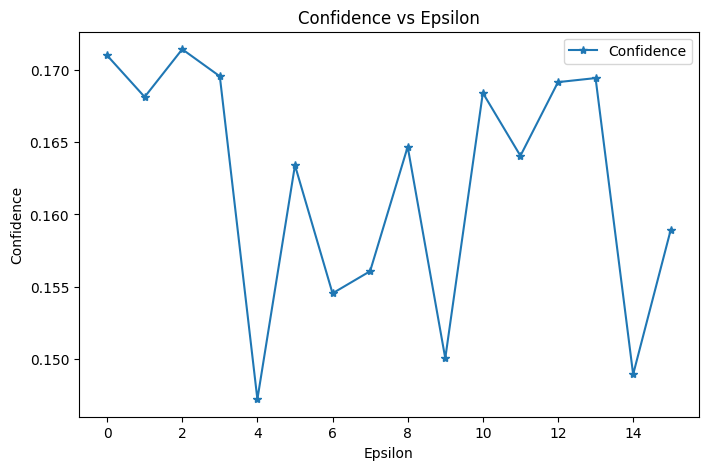

In [31]:
plt.figure(figsize=(8,5))
#plt.plot(epsilons, [confidence.detach().numpy() for confidence in confidences], "*-")
plt.plot( confidence.detach().numpy(), "*-")
plt.title("Confidence vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Confidence")
plt.legend(["Confidence"])
plt.show()
